# Using `enterprise` to analyze single pulsar noise

In this notebook you will learn:
* How to use `enterprise` to interact with NANOGrav data,
* How to search a single pulsar for a common red process,
* How to use the Savage-Dickey approximation to estimate a Bayes factor.

# Load packages and modules

In [63]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import sys
sys.path.append("..")
from settings import fd_bins

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = '../data'
if not os.path.isdir(datadir):
    datadir = '../../data'
print(datadir)

../../data


In [4]:
# get only J1909
psrname = 'J1909'
parfiles = sorted(glob.glob(datadir + '/par/' + psrname + '*par'))
timfiles = sorted(glob.glob(datadir + '/tim/' + psrname + '*tim'))

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]
print(parfiles)
print(timfiles)

['../../data/par/J1909-3744_NANOGrav_12yv3.gls.par']
['../../data/tim/J1909-3744_NANOGrav_12yv3.tim']


## Load in Pulsar class list
* The `enterprise` Pulsar class uses `libstempo` (or optionally `PINT`) to read in `par` and `tim` files, then stores all pulsar data into a `Pulsar` object. This object contains all data and meta-data needed for the ensuing pulsar and PTA analysis. You no longer need to reference the `par` and `tim` files after this cell.
* Note below that you can explicitly declare which version of the JPL solar-system ephemeris model that will be used to compute the Roemer delay between the geocenter and the barycenter (e.g. `DE438`). Otherwise the default values will be taken from the `par` files. Explicitly declaring the version here is good practice.

In [6]:
psrs = []
ephemeris = 'DE438'
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

* We can read-in some previously computed noise properties from single-pulsar white noise analyses. These are things like `EFAC`, `EQUAD`, and (for `NANOGrav`) `ECORR`. 
* In practice, we set these white-noise properties as fixed in the low-frequency noise / GW searches.
* See `singlepulsar_whitenoise_analysis.ipynb` to see an example script that can be used to find these values.
* The noise values have been stored as `json` files, and are read in to a dictionary.

In [7]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}  # dictionary for noise parameters
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

* In a full PTA analysis we fix all of the white noise (EFAC, EQUAD, and ECORR) parameters to the values obtained from the noise files. This is done by using `Constant` parameters. In this case we do not specify a default value for all instances of that parameter but instead will set them, based on their initialized pulsar and backend specific name later via the `set_default_params` method of `PTA`.

* For a single pulsar, it is not necessary to set the white noise as constant, but the computation time will increase with the increase in number of parameters. For this notebook, we set it as constant.

* We use the `Selection` object to define which noise parameters are assigned to which chunks of TOAs. This selection is based on unique combination of backends and receivers.

In [8]:
# define selection by observing backend
selection = selections.Selection(selections.by_backend)

## Pulsar Model

* Now we're ready to start creating the model

In [9]:
# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

### Priors
* For this **detection** search, we will use a `Uniform` prior on both the log of the intrinsic and common red noise, and set the white noise parameters as `Constant` with values added in later from the noise dictionary.

* In the single pulsar case, a varying spectral index (gamma) would be completely covariant with the intrinsic red noise, so we fix it here to 13/3 ~ 4.33.

In [12]:
# white noise parameters
efac = parameter.Constant()
equad = parameter.Constant()
ecorr = parameter.Constant() # we'll set these later with the params dictionary

# red noise parameters
log10_A = parameter.Uniform(-20, -11)
gamma = parameter.Uniform(0, 7)

# GW parameters (initialize with names here to use parameters in common across pulsars)
log10_A_gw = parameter.Uniform(-18, -12)('log10_A_gw')
gamma_gw = parameter.Constant(4.33)('gamma_gw')

### Signals

* Now we attach the priors above to signal objects. These objects can be added together to create the full model which can operate on each pulsar resulting in the full PTA object.


In [13]:
# white noise
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)
eq = white_signals.EquadNoise(log10_equad=equad, selection=selection)
ec = white_signals.EcorrKernelNoise(log10_ecorr=ecorr, selection=selection)

# red noise (powerlaw with 30 frequencies)
pl = utils.powerlaw(log10_A=log10_A, gamma=gamma)
rn = gp_signals.FourierBasisGP(spectrum=pl, components=30, Tspan=Tspan)

# gwb (no spatial correlations)
# Note that the number of components here is changed to line up with the search in the full PTA search
cpl = utils.powerlaw(log10_A=log10_A_gw, gamma=gamma_gw)
gw = gp_signals.FourierBasisGP(spectrum=cpl, components=5, Tspan=Tspan, name='gw')

# timing model
tm = gp_signals.TimingModel(use_svd=True)

In [14]:
# create full model
s = ef + eq + ec + rn + tm + gw

In [15]:
# intialize PTA (this cell will take ~30s to run)
models = []

for p in psrs:    
    models.append(s(p))

pta = signal_base.PTA(models)

In [16]:
# set white noise parameters with dictionary
pta.set_default_params(params)

## Sampling

* Now we need to sample the posterior!
* `PTMCMCSampler` is a parallel tempering Metropolis-Hastings sampler with adaptive jump proposals.
* This means that the sampler will take the log-likelihood and the log-prior and get the samples from the posterior.
* By using additional cores with MPI, we can activate the parallel tempering part of `PTMCMCSampler`, but this is not covered in this tutorial.
* `PTMCMCSampler` has been used for several years with NANOGrav data, and it is tuned quite well to sample from these types of posteriors even with high numbers of dimensions.

In [18]:
# set initial parameters drawn from prior
x0 = np.hstack([p.sample() for p in pta.params])
ndim = len(x0)

In [22]:
# set up the sampler:
# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2)
outDir = '../../chains/sngl_gwb_verbose'

sampler = ptmcmc(ndim, pta.get_lnlikelihood, pta.get_lnprior, cov,
                 outDir=outDir, resume=False)

In [23]:
# sampler for N steps (this should take about 30 mins.)
# uncomment the last line to sample
# We have included chains so that you do not need to sample yourself.
N = int(1e6)
x0 = np.hstack([p.sample() for p in pta.params])
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [103]:
# Uncomment this one to load the chain if you have sampled with PTMCMCSampler:
# chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))

# This will load the chain that we have provided:
chain = np.load(os.path.join(outDir, 'chain_1.npz'))['arr_0']

burn = int(0.25 * chain.shape[0])  # remove burn in segment of sampling

In [104]:
ind = list(pta.param_names).index('log10_A_gw')

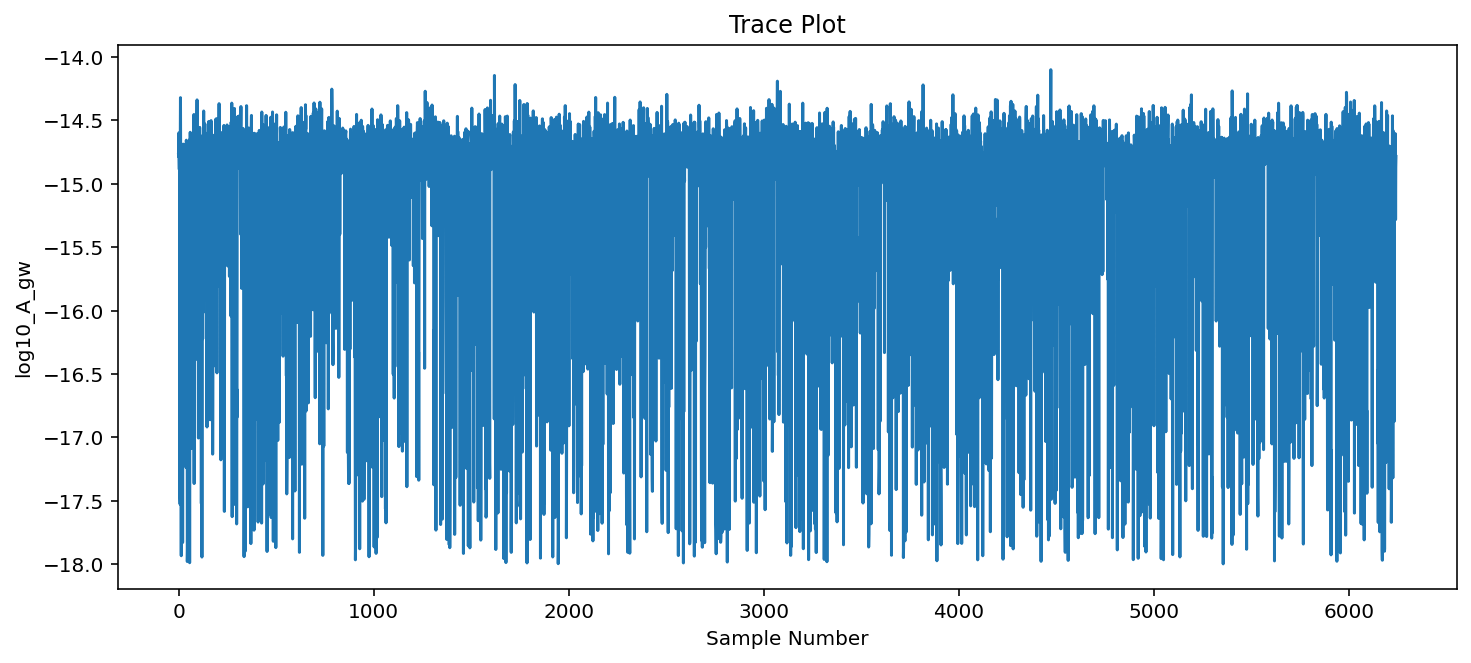

In [105]:
# Make trace-plot to diagnose sampling
plt.figure(figsize=(12, 5))
plt.plot(chain[burn:, ind])
plt.xlabel('Sample Number')
plt.ylabel('log10_A_gw')
plt.title('Trace Plot')
plt.show()

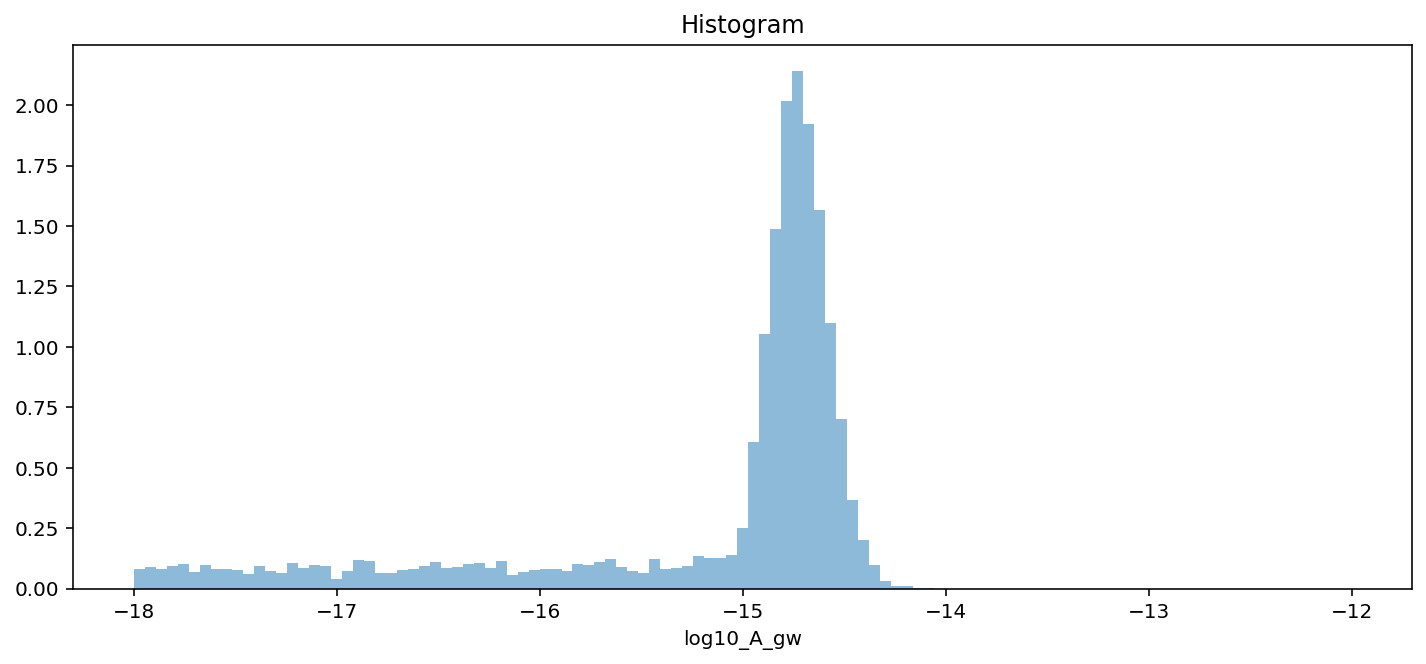

In [106]:
# Plot a histogram of the marginalized posterior distribution
bins = fd_bins(chain[burn:, ind], logAmin=-18, logAmax=-12)  # let FD rule decide bins (in ../settings.py)
plt.figure(figsize=(12, 5))
plt.title('Histogram')
plt.hist(chain[burn:,ind], bins=bins, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5, density=True)
plt.xlabel('log10_A_gw')
plt.show()

In [107]:
hist = np.histogram(chain[burn:, ind],
                    bins=bins,
                    density=True)
max_ind = np.argmax(hist[0])
print('Our max =', hist[1][max_ind])  # from our computation

Our max = -14.760110789930494


## Discussion

* The posterior shows that this pulsar probably prefers a common red process. We can see this by examining the left side of the plot. There is still a tail that exists and extends out to the lower limit of our prior that has shown up in the posterior, so it is not *strongly* preferred. We can quantify this by finding the Bayes factor.
* `12p5yr_maxlike.json` shows `gw_log10_A` = -14.78 from the full 12.5 year GWB search
* Our maximum is pretty close to what was found in the single pulsar, `J1909` analysis at `gw_log10_A` = -14.76

## Savage Dickey Approximation for Bayes factor
* As long as the posterior has a tail that extends to the lower limit of the prior with enough samples, we can compare that tail with the prior to compute a quick Bayes factor
* To do this, we take a function from `enterprise_extensions` which will divide the prior 

In [108]:
from enterprise_extensions.model_utils import bayes_fac

In [110]:
# logAmin, logAmax refer to the limits of the uniform prior on log10_A
# ntol will drop bins if they have fewer than ntol samples
bf = bayes_fac(chain[burn:,ind], ntol=0, logAmin=-18, logAmax=-12)
print('Bayes factor:', bf[0], '+/-', bf[1])

Bayes factor: 2.187942064141544 +/- 0.41225734130726366


In [111]:
log10_bf = np.log10(bf[0])
print('log10(Bayes factor):', log10_bf)

log10(Bayes factor): 0.3400358178639715


## Remarks
* J1909 alone appears to prefer the common red process, but in order to build up the Bayes factor, we need to add in more pulsars.